In [1]:
import torch_geometric
import json
import torch.utils.data as data
import numpy as np
import tqdm, random
import torch, math
import torch.utils.data as data
import torch.nn.functional as F
import torch_cluster
import matplotlib.pyplot as plt


class CATHDataset:
    '''
    Loader and container class for the CATH 4.2 dataset downloaded
    from http://people.csail.mit.edu/ingraham/graph-protein-design/data/cath/.
    
    Has attributes `self.train`, `self.val`, `self.test`, each of which are
    JSON/dictionary-type datasets as described in README.md.
    
    :param path: path to chain_set.jsonl
    :param splits_path: path to chain_set_splits.json or equivalent.
    '''
    def __init__(self, path, splits_path, top_k=30, device="cpu"):
        self.top_k = top_k
        self.device = device
        with open(splits_path) as f:
            dataset_splits = json.load(f)
        train_list, val_list, test_list = dataset_splits['train'], \
            dataset_splits['validation'], dataset_splits['test']
        
        self.train, self.val, self.test = [], [], []
        
        with open(path) as f:
            lines = f.readlines()
        
        for line in tqdm.tqdm(lines):
            entry = json.loads(line)
            name = entry['name']
            coords = entry['coords']
            
            entry['coords'] = list(zip(
                coords['N'], coords['CA'], coords['C'], coords['O']
            ))
            
            if name in train_list:
                self.train.append(entry)
            elif name in val_list:
                self.val.append(entry)
            elif name in test_list:
                self.test.append(entry)
    def get_his(self, dataset):
        distance = []
        for i in range(len(dataset)):
            protein = dataset[i]
            name = protein['name']
            coords = torch.as_tensor(protein['coords'], 
                                     device=self.device, dtype=torch.float32)   
            mask = torch.isfinite(coords.sum(dim=(1,2)))
            coords[~mask] = np.inf
            
            X_ca = coords[:, 1]
            edge_index = torch_cluster.knn_graph(X_ca, k=self.top_k)
            E_vectors = X_ca[edge_index[0]] - X_ca[edge_index[1]]
            E_vectors = E_vectors.norm(dim=-1)
            distance.extend(E_vectors.tolist())
        return distance



In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"

cath = CATHDataset(path="data/chain_set.jsonl",
                            splits_path="data/chain_set_splits.json")    

val_distance = cath.get_his(cath.val)
# val_distance = np.array(val_distance)
train_distance = cath.get_his(cath.train)
train_distance.extend(val_distance)
train_distance = np.array(train_distance)


100%|██████████| 21668/21668 [00:26<00:00, 831.41it/s] 


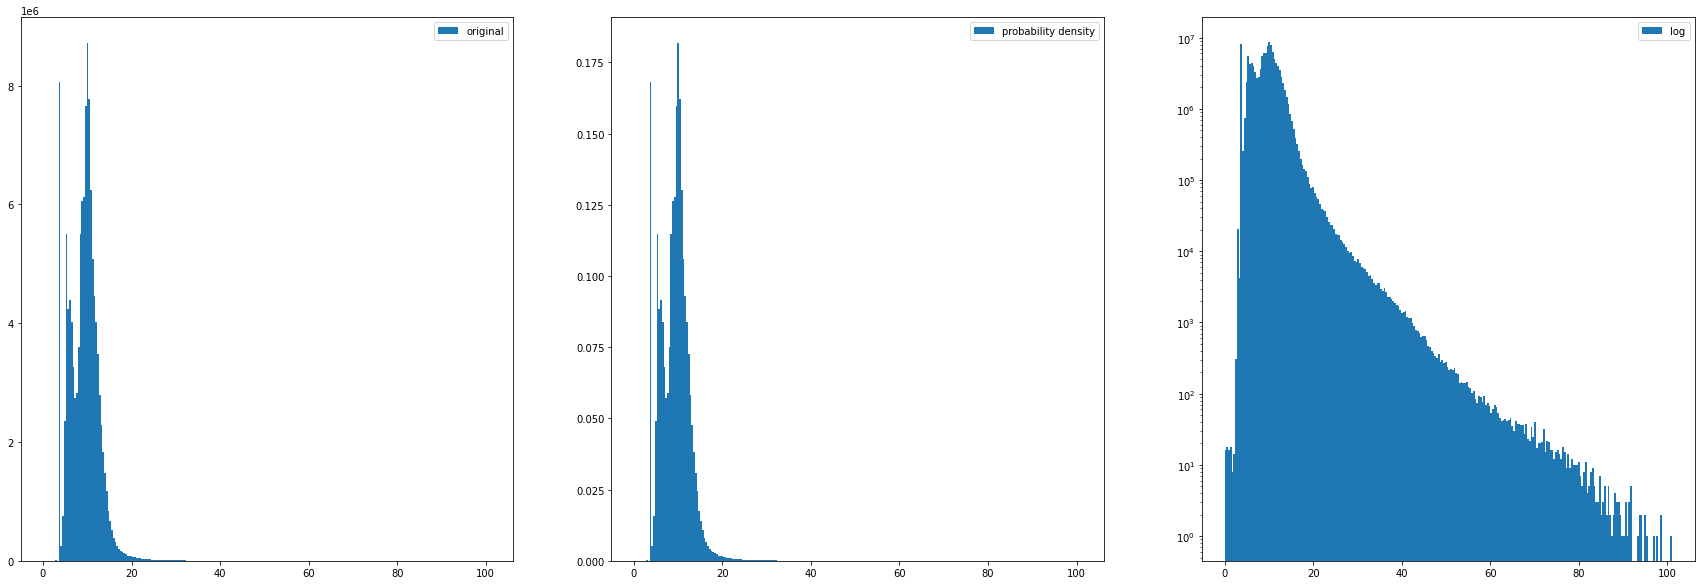

In [3]:


fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(131)
n, bins, patches = plt.hist(train_distance,bins=256,label="original")  
plt.legend()
ax2 = fig.add_subplot(132)
n, bins, patches = plt.hist(train_distance,bins=256,density=True,label="probability density")
plt.legend()  
ax3 = fig.add_subplot(133)
n, bins, patches = plt.hist(train_distance,bins=256,log=True,label="log")  
plt.legend()
plt.show()



